# Language Model Training Pipeline

*Currently only tested for GPT2!* 

#### Imports

In [1]:
import glob
import json
import time
import torch
# import evaluate
import transformers
import numpy as np
import pandas as pd
import evaluate

from sklearn.metrics import top_k_accuracy_score
from pathlib import Path
from tqdm.auto import tqdm
from datasets import Dataset
from tokenizers import Tokenizer
from tokenizers.normalizers import (Sequence, Lowercase, NFD, StripAccents)
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.decoders import BPEDecoder
from transformers import AutoConfig, \
    DataCollatorWithPadding, AutoModelForSequenceClassification, \
    Trainer, TrainingArguments, AutoTokenizer, GPT2Config
from matplotlib import pyplot as plt

### Config

In [2]:
data_path = Path("/home/jliu/ttmp/PBSCSR/")
'''Path to large data folder'''

seed = 42
'''Random seed: int'''

gpt2_dir = data_path/"gpt2"
gpt2_dir.mkdir(exist_ok=True)

train_file = gpt2_dir/"LM_pretraining_data/train.txt"
train_file.parent.mkdir(exist_ok=True)
valid_file = gpt2_dir/"LM_pretraining_data/valid.txt"

pretrained_output = gpt2_dir/"pretrained_model"
pretrained_output.mkdir(exist_ok=True, parents=True)

cache_dir = data_path/".cache"
cache_dir.mkdir(exist_ok=True)
'''Path to save cache'''

labeled_data_path = "../../9_way_dataset.zip"  # TODO: FILL IN AFTER UNZIPPING
'''Path to labeled data'''
classifier_output_dir = gpt2_dir/"classifier"
classifier_output_dir.mkdir(exist_ok=True, parents=True)

### Helper Functions

In [3]:

def process_filler(filler_file, imslp_bootleg_path, filler_threshold=0.5):
    composer_dict = {}
    with open(filler_file, "r") as fin:
        lines = fin.readlines()
        lines = [line.split("\t") for line in lines]
        for path, page, score in lines:
            parts = path.split("/")
            composer, piece, id = parts[0], "/".join(parts[1:-1]), parts[-1]
            composer_dict[composer] = {} if composer not in composer_dict else composer_dict[composer]
            composer_dict[composer][piece] = {} if piece not in composer_dict[composer] else composer_dict[composer][piece]
            composer_dict[composer][piece][id] = {"valid_pages":[], "count":0, "bscore": []} if id not in composer_dict[composer][piece] else composer_dict[composer][piece][id]
            if float(score) < filler_threshold:
                bscore_page = pd.read_pickle(imslp_bootleg_path/f"{path}.pkl")[int(page)]
                composer_dict[composer][piece][id]["valid_pages"].append(int(page))
                composer_dict[composer][piece][id]["count"] += len(bscore_page)
                composer_dict[composer][piece][id]["bscore"].append(bscore_page)
    return composer_dict


def ints_to_binary_matrix(score_seq):  # converts integer sequence to n x 62 matrix
    matrix = []
    for event in score_seq:
        binary_rep = list(np.binary_repr(event, 62))
        matrix.append(binary_rep)
    np_mat = np.array(matrix, dtype=np.uint8)
    #np_mat = np.flip(np_mat, axis=0)  # flip to have least significant bit at the front
    return np_mat


def create_dataset(pieces, valid_split=.15, test_split=.15):
    """
    Creates a train / valid / test split dataset of pieces.
    pieces: The list of binary_matrices to sample from
    valid_split: The proportion of data to use for valid
    test_split: The proportion of data to use for valid
    
    returns:
    x & y lists for train, valid, and test sets
    """
    
    # For repeatability
    np.random.seed(42)

    # shuffle pieces
    piece_list = [piece for piece in pieces]
    np.random.shuffle(piece_list)
    
    # Calculate starting places of each section - order is (test, valid, train)
    train_start = round((valid_split+test_split)*len(piece_list))
    valid_start = round(test_split*len(piece_list))
    
    # Go through and separate pieces into train, valid, test
    train_pieces = piece_list[train_start:]
    valid_pieces = piece_list[valid_start:train_start]
    test_pieces = piece_list[:valid_start]
    
    return train_pieces, valid_pieces, test_pieces

def merge_staff_overlaps(bscores):
    """
    Takes in either one binary score or a batch of them and merges the left and right hands
    """
    
    # Lower middle c is index 23
    # Upper middle c is index 33
    lower = 23
    upper = 33
    middle = (lower + upper) // 2
    
    # Total notes is 52
    total = 52
    
    # Pad out upper hand and lower hand and combine them
    padded_lower = np.concatenate([bscores[..., :middle], np.zeros((*bscores.shape[:-1], total-middle))], axis=-1)
    padded_upper = np.concatenate([np.zeros((*bscores.shape[:-1], middle-bscores.shape[-1]+total)), bscores[..., middle:]], axis=-1)
    # Logical or
    merged = padded_lower + padded_upper - padded_lower * padded_upper
    return merged


# Dense Encoder

# Continuous line of 256 unicode characters
start = 10060# 931
dense_characters = [chr(i).encode("utf-8").decode("utf-8") for i in range(start, start+512)]


# This code divides the fragment into blocks (and discards any remaining info at the very edges)
# Then it uses einsum with a filter of powers of 2 to convert from binary to an integer.  Then converts integers into
# unicode characters

def dense_encoder(fragment, block_size=[1, 8]):
    fragment = merge_staff_overlaps(fragment)
    # Rewrote this to be much faster but looks complicated
    # This filter has powers of 2 which is how the binary is turned to ints
    filter_ = np.power(2, np.arange(np.prod(block_size))).reshape(block_size)
    
    # The fragment is split into blocks here
    xblocks = np.stack(np.split(fragment[:, :(fragment.shape[1]//block_size[1])*block_size[1]], fragment.shape[1]//block_size[1], axis=1))
    xyblocks = np.stack(np.split(xblocks[:, :(xblocks.shape[1]//block_size[0])*block_size[0]], xblocks.shape[1]//block_size[0], axis=1))
    
    # The blocks are multiplied so they are ints
    numbers = np.einsum("ijkl,kl->ij", xyblocks, filter_)
    
    # The ints are turned into corresponding characters
    characters = (numbers+start).astype(np.int32).view('U1')
    return " ".join(["".join(t) for t in characters])

def data_preparation(labeled_data):
    """Prepare data for training, validation, and testing.
    
    Returns
    -------
    train_df : pd.DataFrame
        Training data with 2 columns, "text" and "label".
    val_df : pd.DataFrame
        Validation data with 2 columns, "text" and "label".
    test_df : pd.DataFrame
        Testing data with 2 columns, "text" and "label".
    """

    d = pd.read_pickle(labeled_data)
    train_X, train_y, val_X, val_y, test_X, test_y = d[0], d[1], d[2], d[3], d[4], d[5]

    train_df = pd.DataFrame({"bscore": train_X, "label": train_y})
    val_df = pd.DataFrame({"bscore": val_X, "label": val_y})
    test_df = pd.DataFrame({"bscore": test_X, "label": test_y})

    train_df["text"] = train_df["bscore"].apply(dense_encoder)
    val_df["text"] = val_df["bscore"].apply(dense_encoder)
    test_df["text"] = test_df["bscore"].apply(dense_encoder)
    
    return train_df, val_df, test_df

def label2id_function(examples, label2id):
    return {"label": [label2id[label] for label in examples["label"]]}

def tokenizer_function(examples, tokenizer):
    return tokenizer(examples["text"], padding='max_length', truncation=True)

### Prep Data

In [ ]:
# Clone IMSLP bootleg scores
repo_path = data_path/"piano_bootleg_scores"
# !git clone https://github.com/HMC-MIR/piano_bootleg_scores.git {repo_path}
piano_bootleg_scores_path = repo_path/"imslp_bootleg_dir-v1"

# Grab all file locations
piece_names = glob.glob(str(Path(piano_bootleg_scores_path)/"**/*"))
# This gets every version of every piece
fnames = glob.glob(str(piano_bootleg_scores_path/"**/*.pkl"), recursive=True)


# Filter out filler
composer_dict = process_filler("../../filler.tsv", piano_bootleg_scores_path, filler_threshold=0.5)

# CONVERTING THE DATA TO BINARY MATRICES - MIGHT TAKE A MINUTE

t0 = time.time()
# List of tuples containing (binary_score, composer)
pieces = []
for composer in tqdm(composer_dict):
    for piece in composer_dict[composer]:
        for id in composer_dict[composer][piece]:
            # Get the pages
            pages = composer_dict[composer][piece][id]["bscore"]
            # Convert them into binary matrices
            bscores = [ints_to_binary_matrix(page) for page in pages]

            if len(bscores) > 0:
                p = np.concatenate(bscores, axis=0)
                pieces.append((p, composer))

print("Seconds to complete:", round(time.time() - t0))

# Split up data to train and valid
train, valid, test = create_dataset(pieces, valid_split=.2, test_split=0)

# Encode and save data LM pretraining data
train_encoded = []
for piece in tqdm(train):
    train_encoded.append(dense_encoder(piece[0], block_size=[1,8]))
valid_encoded = []
for piece in tqdm(valid):
    valid_encoded.append(dense_encoder(piece[0], block_size=[1,8]))

train_file = gpt2_dir/"LM_pretraining_data/train.txt"
train_file.parent.mkdir(exist_ok=True)
valid_file = gpt2_dir/"LM_pretraining_data/valid.txt"
valid_file.parent.mkdir(exist_ok=True)
with open(train_file, "w") as f:
    f.write("\n\n".join(train_encoded))
with open(valid_file, "w") as f:
    f.write("\n\n".join(valid_encoded))

### Train BPE Tokenizer

In [5]:
vocab_size = 30_000
'''Vocab size for tokenizer: int'''
special_tokens = []
'''Special tokens for tokenizer: list of strings'''

tokenizer_path = gpt2_dir/"tokenizer"/"tokenizer.json"
tokenizer_path.parent.mkdir(exist_ok=True, parents=True)

# Define tokenizer
tokenizer = Tokenizer(BPE())
tokenizer.normalizer = Sequence([NFD(),Lowercase(),StripAccents()])
tokenizer.pre_tokenizer = Whitespace()
tokenizer.decoder = BPEDecoder()
trainer = BpeTrainer(vocab_size=vocab_size, special_tokens=special_tokens)
tokenizer.train([str(train_file)], trainer=trainer) 
tokenizer.save(str(tokenizer_path))

### Language Model Pretraining

*Run the cell below and it will output an LM training shell script in the output model directory you specify. Navigate to that directory and run the shell script in a persistent shell session (TMUX) with the corresponding Python environment*

In [4]:
# Language Model Config
config_class = GPT2Config
'''Config class for language model: e.g. GPT2Config'''

lm_config = {
    'model_type': 'gpt2', # e.g. 'gpt2',
    'vocab_size': 30_000, # e.g. 50257,
    'n_positions': 1024, # e.g. 1024,
    'n_layer': 6, # e.g. 12,
    # add more config here if needed
}
'''Config for language model: dict
See https://huggingface.co/transformers/model_doc/gpt2.html#gpt2config for an example for GPT2'''

lm_config_str = "\"" + ",".join(f"{k}={v}" for k,v in lm_config.items()) + "\""

# Write out config to tokenizer directory for internal HuggingFace use
with open(str(tokenizer_path.parent/"config.json"), 'w') as fp:
    json.dump(lm_config, fp)


# Create training shell script
cmd = f''' 
torchrun  --nproc_per_node 2
{Path.cwd()/"run_clm.py"}
--model_type {lm_config["model_type"]}
--tokenizer_name {tokenizer_path.parent.resolve()}
--train_file {train_file.resolve()}
--validation_file {valid_file.resolve()}
--output_dir {pretrained_output.resolve()}
--do_train
--do_eval
--evaluation_strategy steps
--per_device_train_batch_size 8
--per_gpu_eval_batch_size 8
--learning_rate 1e-4
--num_train_epochs 12
--logging_steps 2000
--save_steps 2000
--seed {seed}
--overwrite_output_dir
--local_rank 0
--cache_dir {cache_dir}
--config_overrides="{lm_config_str}"
'''.replace("\n", " ")

# Write out training shell script to output model directory
with open(str(pretrained_output/"train_lm.sh"), "w") as fout:
    fout.write(cmd)

NameError: name 'tokenizer_path' is not defined

### Language Model Pretraining Curves

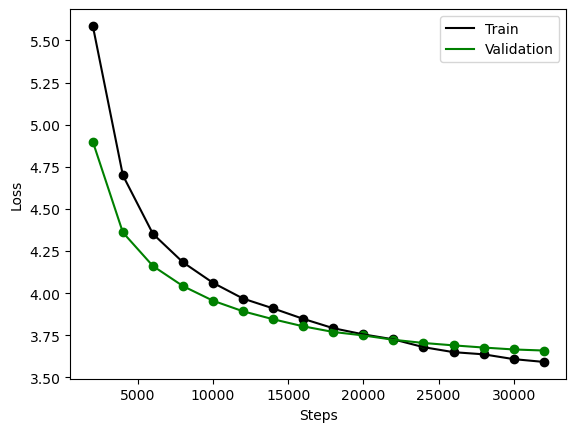

In [4]:
tr_loss = []
val_loss = []
accuracy = []
step = []

with open(pretrained_output/"trainer_state.json", 'r') as f:
    log_history = json.load(f)['log_history']
    for entry in log_history:
        if "loss" in entry:
            step.append(int(entry["step"]))
            tr_loss.append(float(entry["loss"]))
        elif "eval_loss" in entry:
            val_loss.append(float(entry["eval_loss"]))

        if "eval_accuracy" in entry:
            accuracy.append(float(entry["eval_accuracy"]))

step, tr_loss, val_loss, acc = np.array(step), np.array(tr_loss), np.array(val_loss), np.array(accuracy)
plt.plot(step, tr_loss, 'k-', label="Train")
plt.scatter(step, tr_loss, c='k')
plt.plot(step, val_loss, 'g-', label="Validation")
plt.scatter(step, val_loss, c='g')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

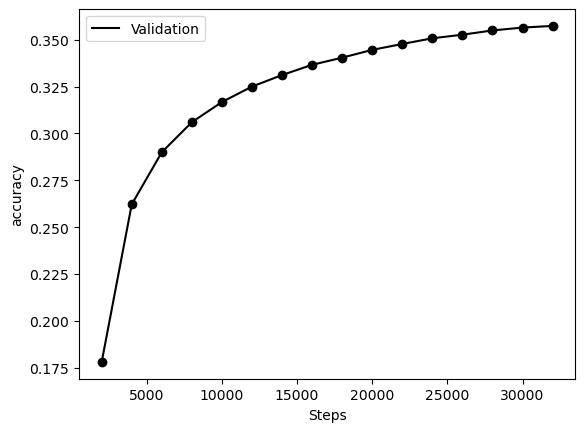

In [5]:

plt.plot(step, acc, 'k-', label="Validation")
plt.scatter(step, acc, c='k')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('accuracy')
plt.show()

### Language Model Linear Probe Classifier

Prewritten Helper Functions & Classes

In [ ]:
# def top_x_acc(y_true, y_pred, x)
#     y_true = torch.tensor(y_true)
#     y_pred = torch.tensor(y_pred)
#     ranked = torch.argsort(y_pred, axis=-1)
#     top_x = ranked[..., -x:]
#     return (top_x == torch.repeat_interleave(y_true.unsqueeze(-1), x, axis=-1)).float().sum(-1).mean().item()

# def mean_recip_rank(y_true, y_pred):
#     y_true = torch.tensor(y_true)
#     y_pred = torch.tensor(y_pred)
#     ranked = torch.argsort(y_pred, axis=-1)
#     true_ranks = y_pred.shape[-1] - (ranked == torch.repeat_interleave(y_true.unsqueeze(-1), y_pred.shape[-1], axis=-1)).float().argmax(-1)

#     return (1/true_ranks).mean().item()
# def compute_metrics(eval_pred):
#     print(eval_pred)

#     predictions, labels = eval_pred
#     # predictions = np.argmax(predictions, axis=1)

#     top_one = top_x_acc(labels, predictions, 1)
#     top_five = top_x_acc(labels, predictions, 5)
#     mrr = mean_recip_rank(labels, predictions)

#     metrics = {"top_one" : top_one, "top_five" : top_five, "mrr": mrr}
#     return metrics


Training Classifier

In [ ]:

# batch_size = 32
# '''Batch size for classifier training: int'''
# epochs = 12
# '''Epochs for classifier training: int'''
# learning_rate = 5e-5
# '''Learning rate for classifier training: float e.g. 5e-5'''

# # Prepare data
# # !unzip -o {labeled_data_path} -d {data_path} 
# labeled_data = data_path/"9_way_dataset.pkl"
# train_df, val_df, test_df = data_preparation(labeled_data)
# train_ds = Dataset.from_dict(train_df)
# val_ds = Dataset.from_dict(val_df)
# test_ds = Dataset.from_dict(test_df)

# # Define label map
# label2id = {label: i for i, label in enumerate(set(train_df['label']))}
# id2label = {i: label for label, i in label2id.items()}

# # Load Tokenizer
# tokenizer = AutoTokenizer.from_pretrained(pretrained_output)
# tokenizer.pad_token = '<pad>'


# # Define model
# config = AutoConfig.from_pretrained(pretrained_output)
# config.num_labels = len(label2id)
# config.pad_token_id = tokenizer.pad_token_id
# model = AutoModelForSequenceClassification.from_pretrained(pretrained_output, config=config)
# tokenizer.model_max_length = config.n_positions

In [ ]:

# # Tokenize and convert labels to ids
# train_ds = train_ds.map(tokenizer_function, batched=True, fn_kwargs={"tokenizer": tokenizer})
# val_ds = val_ds.map(tokenizer_function, batched=True, fn_kwargs={"tokenizer": tokenizer})
# train_ds = train_ds.map(label2id_function, batched=True, fn_kwargs={"label2id": label2id})
# val_ds = val_ds.map(label2id_function, batched=True, fn_kwargs={"label2id": label2id})

# data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest", max_length=1024)

# # Freeze all layers except the classifier
# for name, param in model.named_parameters():
#     param.requires_grad = False
# model.score.weight.requires_grad = True


# # Define training arguments
# training_args = TrainingArguments(
#     output_dir=classifier_output_dir,
#     learning_rate=learning_rate,
#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,
#     num_train_epochs=epochs,
#     weight_decay=0.01,
#     logging_strategy="epoch",
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     load_best_model_at_end=True,
#     push_to_hub=False,
# )

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_ds,
#     eval_dataset=val_ds,
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     compute_metrics=compute_metrics,
# )

# # Train model
# trainer.train()

In [ ]:
# # with open("/home/abunn/ttmp/ExplorationWithLLMs/source/03_alec_temp_name/finetuned_models/dense_1_8/log_history.json", "r") as fin:
#     log_history = json.load(fin)

# step, tr_loss, val_loss = [], [], []
# acc = []
# for epoch in log_history:
#     step.append(epoch["epoch"])
#     tr_loss.append(epoch["train_loss"])
#     val_loss.append(epoch["val_loss"])
#     acc.append(epoch["accuracy"])

# step, tr_loss, val_loss = np.array(step), np.array(tr_loss), np.array(val_loss)
# plt.plot(step, tr_loss, 'k-', label="Train")
# plt.scatter(step, tr_loss, c='k')
# plt.plot(step, val_loss, 'g-', label="Validation")
# plt.scatter(step, val_loss, c='g')
# plt.legend()
# plt.xlabel('Steps')
# plt.ylabel('Loss')
# plt.show()

In [ ]:
# plt.plot(step, acc, 'g-', label="Validation")
# plt.scatter(step, acc, c='g')
# plt.legend()
# plt.xlabel('Steps')
# plt.ylabel('Accuracy')
# plt.show()